# Toxic Comment Classification

In [1]:
'''
This script detects toxic comments using a multi-label classification model. 
Several models were built and evaluated, the best models were used for determining
whether or not a comment is considered toxic. 
'''
__author__ = "Mahsa Shokouhi"
__email__ = "mahsa_shokouhi@yahoo.com"

# Import Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, hamming_loss,
                             classification_report, multilabel_confusion_matrix)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer

from skmultilearn.model_selection import IterativeStratification

from lightgbm import LGBMClassifier

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


pd.set_option('precision', 6)
%matplotlib inline

# Define Functions

In [3]:
def stratified_split (X, Y, test_size):
    '''Stratified train-test split given specified test_size'''
    stratifier = IterativeStratification(n_splits=2, order=2,
                                         sample_distribution_per_fold=[test_size, 
                                                                       1-test_size])
    train_indexes, test_indexes = next(stratifier.split(X, Y))
    X_train, Y_train = X[train_indexes], Y.iloc[train_indexes, :]
    X_test, Y_test = X[test_indexes], Y.iloc[test_indexes, :]
    return X_train, X_test, Y_train, Y_test



def evaluate_model(model, X_train, Y_train, n_folds=3):
    '''Evaluate a model using stratified k-fold cross-validation.
    prints out mean accuracy, mean hamming loss, and mean f1-score across folds'''
    acc_train = []
    acc_test = []
    loss_train = []
    loss_test = []
    f1_train = []
    f1_test =[]

    k_fold = IterativeStratification(n_splits=n_folds, order=2)

    for tr_index, ts_index in k_fold.split(X_train, Y_train):
        model.fit(X_train[tr_index], Y_train.iloc[tr_index])
        pred_train = model.predict(X_train[tr_index])
        pred_test = model.predict(X_train[ts_index])
        acc_train.append(accuracy_score(Y_train.iloc[tr_index], pred_train))
        acc_test.append(accuracy_score(Y_train.iloc[ts_index], pred_test))
        loss_train.append(hamming_loss(Y_train.iloc[tr_index], pred_train))
        loss_test.append(hamming_loss(Y_train.iloc[ts_index], pred_test))
        f1_train.append(f1_score(Y_train.iloc[tr_index], pred_train, average='micro'))
        f1_test.append(f1_score(Y_train.iloc[ts_index], pred_test, average='micro'))

    print('Train set:\n')
    print(f'Mean accuracy score: {np.mean(acc_train)}, \n'
          f'Mean loss: {np.mean(loss_train)}, \n'
          f'Mean F1-score:{np.mean(f1_train)}')
    print('\nTest set:\n')
    print(f'Mean accuracy score: {np.mean(acc_test)}, \n'
          f'Mean loss: {np.mean(loss_test)}, \n'
          f'Mean F1-score:{np.mean(f1_test)}')



def confusion_matrix_df(model, X_test, Y_test):
    '''Create a dataframe of the confusion matrix.'''
    labels = Y_test.columns
    Y_pred = model.predict(X_test)
    cm = multilabel_confusion_matrix(Y_test, Y_pred)
    cm_percent = cm * 100 / X_test.shape[0]
    df = pd.DataFrame(cm_percent.reshape(len(labels), -1), index=list(labels))
    df.columns = ['TN', 'FP', 'FN', 'TP']
    df = df.style.format('{:.1f}')
    return df

# Load Data

## Train set

In [5]:
train = pd.read_csv('Data/train.csv')
print(train.shape)
train.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
# Check for missing values
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Test set

In [7]:
test = pd.read_csv('Data/test.csv')
test_labels = pd.read_csv('Data/test_labels.csv')

# Merge the two sets
test = pd.merge(test, test_labels, how='left', on='id')
print(test.shape)
test.head()

(153164, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [8]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [9]:
# Remove unlabelled rows from the test set (label=-1)
is_labelled = test.drop('comment_text', axis=1) != -1
test = test[is_labelled.all(axis='columns')]
print(test.shape)

(63978, 7)


# Exploratory Data Analysis

In [10]:
# Number of positive samples for each label (toxic types)
print(train.drop('comment_text', axis=1).sum())

# Total number of rows with and without any type of toxic comments
n_nonToxic = train[train.drop('comment_text', axis=1).sum(axis=1) == 0].shape[0]
n_toxic = train.shape[0] - n_nonToxic
print(f'There are {n_nonToxic} non-toxic and {n_toxic} toxic comments')

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
There are 143346 non-toxic and 16225 toxic comments


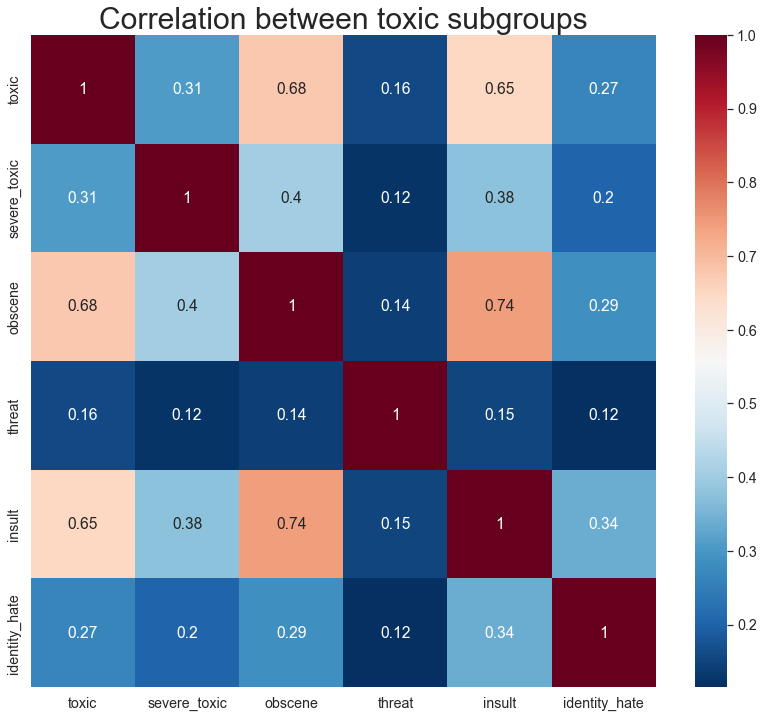

In [11]:
# Check correlation between toxic subgroups
labels = train.drop('comment_text', axis=1).columns

sns.set(font_scale=1.3)
plt.figure(figsize=(14, 12))
sns.heatmap(train.drop('comment_text', axis=1).corr(), 
            xticklabels=labels, 
            yticklabels=labels, 
            cmap="RdBu_r", annot=True)
plt.title('Correlation between toxic subgroups', fontsize=30)
plt.show()

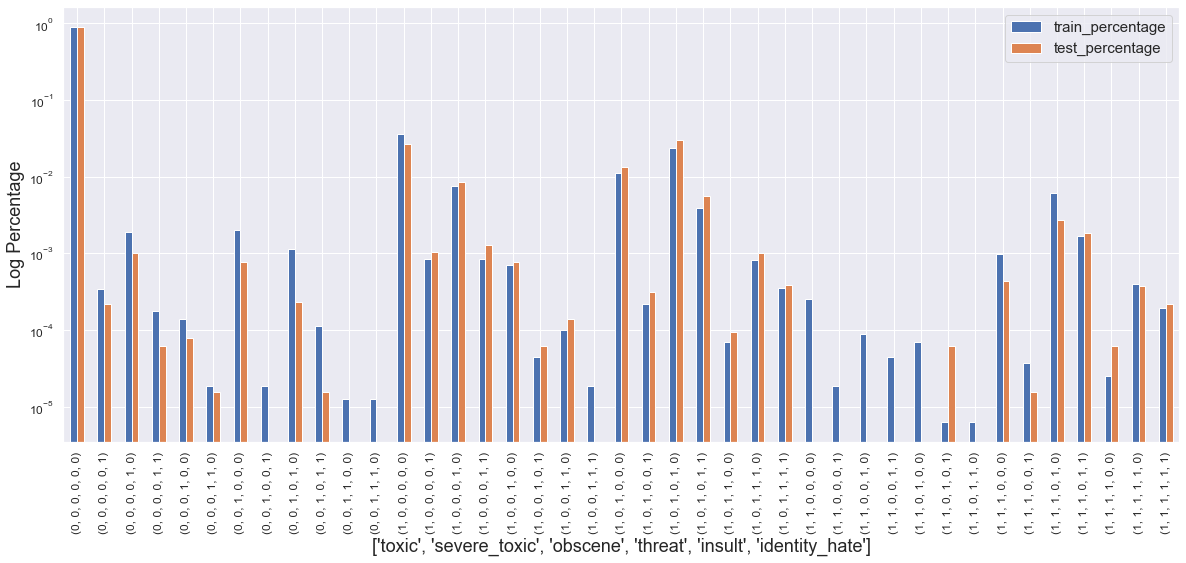

In [12]:
# Compare percentage of labels in the train and test sets

labels = train.drop('comment_text', axis=1).columns
# Train set
train_perentage = pd.DataFrame(
    train.drop('comment_text', axis=1).value_counts(normalize=True, 
                                                    sort=False)).reset_index()
train_perentage.columns = list(labels) + ['train_percentage']

# Test set
test_perentage = pd.DataFrame(
    test.drop('comment_text', axis=1).value_counts(normalize=True, 
                                                   sort=False)).reset_index()
test_perentage.columns = list(labels) + ['test_percentage']


# Merge the tow sets
labels_perentages = pd.merge(train_perentage, test_perentage, 
                             how='left', on=list(labels))

labels_perentages.set_index(list(labels), inplace=True)

# Plot labels frequencies (percentage) for train and test sets
labels_perentages.plot(kind='bar', logy=True, figsize=(20, 8), fontsize=12)
plt.legend(fontsize=15)
plt.xlabel(list(labels), fontsize=18)
plt.ylabel('Log Percentage', fontsize=18)
plt.show()

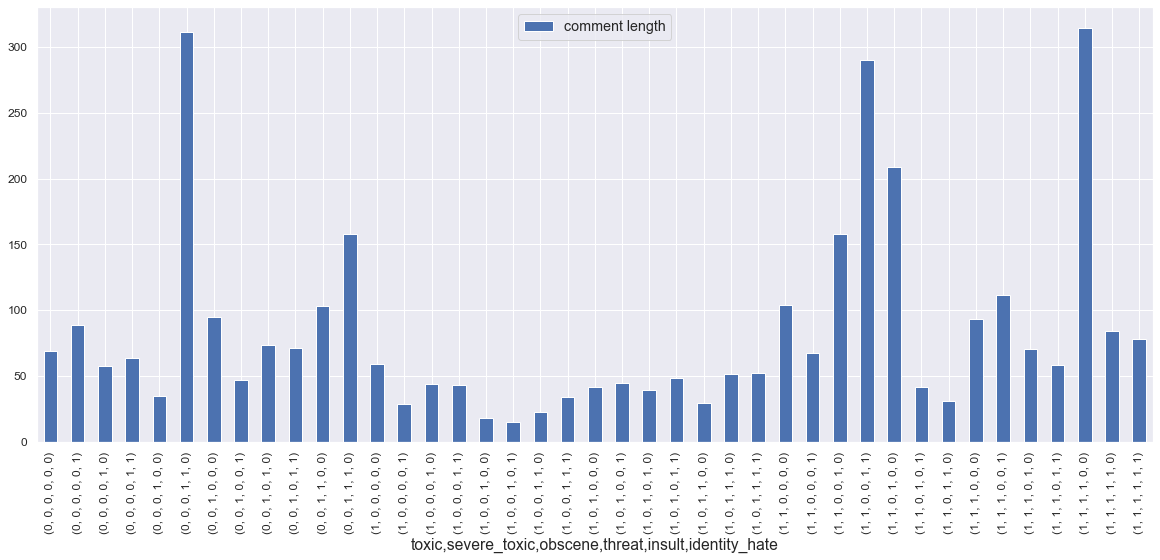

In [13]:
# Mean comment length for each subgroup

labels = train.drop('comment_text', axis=1).columns
comment_length = train['comment_text'].apply(lambda x:len(x.split()))
comment_length.name = 'comment length' 
labels_length = pd.concat([comment_length , train.drop('comment_text', axis=1)], 
                          axis=1)

labels_length.groupby(list(labels)).mean().plot(kind='bar', 
                                                figsize=(20, 8), 
                                                fontsize=12)
plt.show()

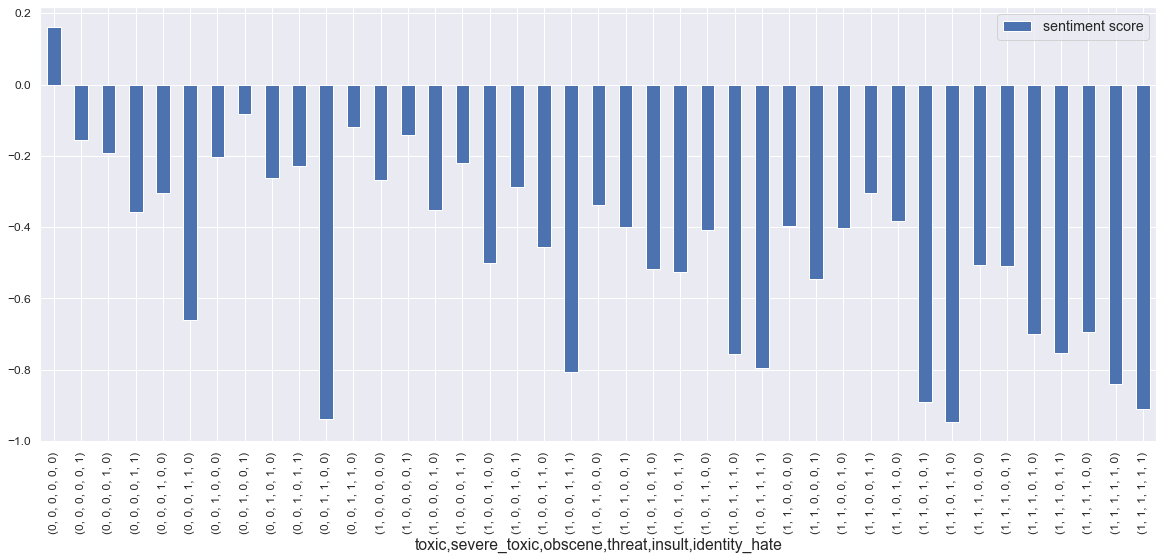

In [14]:
# Comments' sentiments score
labels = train.drop('comment_text', axis=1).columns
sia = SentimentIntensityAnalyzer()

sentiments_train = train['comment_text'].apply(lambda x: sia.polarity_scores(x)
                                               ['compound'])
sentiments_train.name = 'sentiment score'
sentiments_train = pd.concat([
    train.drop('comment_text', axis=1), sentiments_train], axis=1)
sentiments_train.groupby(list(labels)).mean().plot(kind='bar', 
                                                   figsize=(20, 8), 
                                                   fontsize=12)
plt.show()

# Data Preprocessing

In [15]:
# add sentiment score as an additional feature
train['sentiment_score'] = train['comment_text'].apply(
    lambda x: sia.polarity_scores(x)['compound'])
test['sentiment_score'] = test['comment_text'].apply(
    lambda x: sia.polarity_scores(x)['compound'])
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sentiment_score
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0.5574
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0.2942
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,-0.1779
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0.5106
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0.6808


In [14]:
# Grid search for the max number of features with TfidfVectorizer

TVs = [TfidfVectorizer(max_features=5000*i, ngram_range=(1, 2), 
                       strip_accents='unicode', lowercase=True, 
                       stop_words='english') 
       for i in range(1, 11)]

# Target variables: labels
Y = train[list(labels)]

scores = []
losses = []
for i in range(len(TVs)):
    X = TVs[i].fit_transform(train['comment_text'])
    # Train-test split
    X_train, X_test, Y_train, Y_test = stratified_split(X, Y, test_size=0.3)
    # Training
    classifier = ClassifierChain(LogisticRegression(max_iter=5000, 
                                                    random_state=100))
    classifier.fit(X_train, Y_train)
    predicted = classifier.predict(X_test)
    scores.append(accuracy_score(Y_test, predicted))
    losses.append(hamming_loss(Y_test, predicted))

print(f'scores:\n{scores}')
print(f'losses:\n{losses}')

scores:
[0.918511864973262, 0.9195563168449198, 0.9197443181818182, 0.9185954211229946, 0.9189923128342246, 0.9193056483957219, 0.9196189839572193, 0.9197025401069518, 0.9195354278074866, 0.9195354278074866]
losses:
[0.01958347259358289, 0.019235321969696968, 0.019499916443850268, 0.019754066399286986, 0.019830659536541888, 0.019642658199643493, 0.019555620543672013, 0.019729695855614973, 0.01970880681818182, 0.01974362188057041]


In [16]:
# TfidfVectorizer with max_features=10000
tv = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), 
                     strip_accents='unicode', lowercase=True, 
                     stop_words='english') 

# Train set
X_train = train.drop(list(labels), axis=1)
Y_train = train[list(labels)]
transformer = ColumnTransformer([('comment_tf-idf', tv, 'comment_text')],
                                remainder='passthrough')
X_train = transformer.fit_transform(X_train)

# Test set
X_test = test.drop(list(labels), axis=1)
X_test = transformer.transform(X_test)
Y_test = test[list(labels)]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(159571, 10001) (159571, 6) (63978, 10001) (63978, 6)


# Baseline Model

In [18]:
# Define a dummy classifier for comparison
BL = DummyClassifier(strategy='stratified', random_state=100)
BL.fit(X_train, Y_train)
pred_train = BL.predict(X_train)
pred_test = BL.predict(X_test)

print('Classification report for test set')
print(classification_report(Y_test, pred_test, target_names=labels))
print('Classification report for train set')
print(classification_report(Y_train, pred_train, target_names=labels))

Classification report for test set
               precision    recall  f1-score   support

        toxic       0.10      0.10      0.10      6090
 severe_toxic       0.01      0.01      0.01       367
      obscene       0.06      0.05      0.06      3691
       threat       0.00      0.00      0.00       211
       insult       0.06      0.05      0.06      3427
identity_hate       0.02      0.01      0.01       712

    micro avg       0.07      0.07      0.07     14498
    macro avg       0.04      0.04      0.04     14498
 weighted avg       0.07      0.07      0.07     14498
  samples avg       0.01      0.01      0.01     14498

Classification report for train set
               precision    recall  f1-score   support

        toxic       0.09      0.09      0.09     15294
 severe_toxic       0.01      0.01      0.01      1595
      obscene       0.05      0.05      0.05      8449
       threat       0.01      0.01      0.01       478
       insult       0.05      0.05      0.05 

# Classification Model Selection
## Spot-check algorithms

In [20]:
%%time

# 1. Classifier Chains with LogisticRegression
cc_lg = ClassifierChain(LogisticRegression(max_iter=1000,
                                           random_state=100))
evaluate_model(cc_lg, X_train, Y_train, n_folds=3)

Train set:

Mean accuracy score: 0.9270544158806349, 
Mean loss: 0.017211774227665292, 
Mean F1-score:0.725619895426911

Test set:

Mean accuracy score: 0.9201296057840995, 
Mean loss: 0.01916179335635543, 
Mean F1-score:0.691602798366521
CPU times: user 2min 18s, sys: 21.2 s, total: 2min 39s
Wall time: 1min 31s


In [21]:
%%time

# 2. Classifier Chains with RandomForestClassifier
cc_rf = ClassifierChain(RandomForestClassifier(random_state=100))
evaluate_model(cc_rf, X_train, Y_train, n_folds=3)

Train set:

Mean accuracy score: 0.9981481582804718, 
Mean loss: 0.0004950777209325755, 
Mean F1-score:0.9932232935518052

Test set:

Mean accuracy score: 0.9173847425936894, 
Mean loss: 0.019481400420400075, 
Mean F1-score:0.6976210570701776
CPU times: user 1h 2min 31s, sys: 58.1 s, total: 1h 3min 29s
Wall time: 1h 21min 26s


In [22]:
%%time

# 3. Classifier Chains with LGBMClassifier
cc_lgbm = ClassifierChain(LGBMClassifier(random_state=100))
evaluate_model(cc_lg, X_train, Y_train, n_folds=3)

Train set:

Mean accuracy score: 0.9270826172593457, 
Mean loss: 0.017207073457882315, 
Mean F1-score:0.7260328476893342

Test set:

Mean accuracy score: 0.9202236000509915, 
Mean loss: 0.0191973067971106, 
Mean F1-score:0.6907415896343144
CPU times: user 2min 14s, sys: 20.5 s, total: 2min 35s
Wall time: 1min 34s


## Model Tuning and Evaluation

In [23]:
# 1. LogisticRegression
lg = ClassifierChain(LogisticRegression(max_iter=1000, random_state=100))
lg.fit(X_train, Y_train)
predicted = lg.predict(X_test)

print(f'ROC AUC Score: {roc_auc_score(Y_test, lg.predict_proba(X_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(Y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9650979744680116


Classification Report
               precision    recall  f1-score   support

        toxic       0.63      0.72      0.67      6090
 severe_toxic       0.38      0.28      0.32       367
      obscene       0.68      0.68      0.68      3691
       threat       0.38      0.23      0.29       211
       insult       0.60      0.61      0.60      3427
identity_hate       0.70      0.29      0.41       712

    micro avg       0.63      0.64      0.64     14498
    macro avg       0.56      0.47      0.50     14498
 weighted avg       0.63      0.64      0.63     14498
  samples avg       0.06      0.06      0.06     14498



In [24]:
# 2. LogisticRegression with balanced class weights
lg_balanced = ClassifierChain(LogisticRegression(max_iter=1000, 
                                                 random_state=100,
                                                 class_weight='balanced'))
lg_balanced.fit(X_train, Y_train)
predicted = lg_balanced.predict(X_test)

print(f'ROC AUC Score: {roc_auc_score(Y_test, lg_balanced.predict_proba(X_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(Y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9645882542504243


Classification Report
               precision    recall  f1-score   support

        toxic       0.40      0.91      0.56      6090
 severe_toxic       0.07      0.96      0.12       367
      obscene       0.29      0.94      0.44      3691
       threat       0.08      0.89      0.15       211
       insult       0.25      0.94      0.39      3427
identity_hate       0.06      0.94      0.12       712

    micro avg       0.24      0.93      0.38     14498
    macro avg       0.19      0.93      0.30     14498
 weighted avg       0.31      0.93      0.45     14498
  samples avg       0.05      0.09      0.06     14498



In [25]:
# 3. LGBMClassifier with default params
lgbm = ClassifierChain(LGBMClassifier(num_leaves=31, random_state=100))
lgbm.fit(X_train, Y_train)
predicted = lgbm.predict(X_test)

print(f'ROC AUC Score: {roc_auc_score(Y_test, lgbm.predict_proba(X_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(Y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9236790933056626


Classification Report
               precision    recall  f1-score   support

        toxic       0.62      0.71      0.66      6090
 severe_toxic       0.31      0.33      0.32       367
      obscene       0.63      0.68      0.66      3691
       threat       0.23      0.33      0.27       211
       insult       0.55      0.61      0.58      3427
identity_hate       0.63      0.37      0.46       712

    micro avg       0.59      0.65      0.62     14498
    macro avg       0.50      0.50      0.49     14498
 weighted avg       0.59      0.65      0.62     14498
  samples avg       0.06      0.06      0.06     14498



In [26]:
# 4.  LGBMClassifier with tuned parameters
lgbm_tuned = ClassifierChain(LGBMClassifier(num_leaves=40, reg_lambda=0.2, 
                                            random_state=100))
lgbm_tuned.fit(X_train, Y_train)
predicted = lgbm_tuned.predict(X_test)

print(f'ROC AUC Score: {roc_auc_score(Y_test, lgbm_tuned.predict_proba(X_test))}\n\n')
print(f'Classification Report\n'
      f'{classification_report(Y_test, predicted, target_names=labels)}')

ROC AUC Score: 0.9495514115805284


Classification Report
               precision    recall  f1-score   support

        toxic       0.61      0.73      0.66      6090
 severe_toxic       0.36      0.37      0.36       367
      obscene       0.63      0.69      0.66      3691
       threat       0.48      0.39      0.43       211
       insult       0.56      0.62      0.59      3427
identity_hate       0.67      0.37      0.48       712

    micro avg       0.60      0.66      0.63     14498
    macro avg       0.55      0.53      0.53     14498
 weighted avg       0.60      0.66      0.62     14498
  samples avg       0.06      0.06      0.06     14498



In [27]:
confusion_matrix_df(lg, X_test, Y_test)

,TN,FP,FN,TP
toxic,86.5,4.0,2.7,6.9
severe_toxic,99.2,0.3,0.4,0.2
obscene,92.4,1.8,1.9,3.9
threat,99.5,0.1,0.3,0.1
insult,92.4,2.2,2.1,3.3
identity_hate,98.7,0.1,0.8,0.3


In [28]:
confusion_matrix_df(lg_balanced, X_test, Y_test)

,TN,FP,FN,TP
toxic,77.7,12.8,0.8,8.7
severe_toxic,91.6,7.8,0.0,0.5
obscene,80.7,13.5,0.3,5.4
threat,96.4,3.3,0.0,0.3
insult,79.2,15.4,0.3,5.1
identity_hate,83.5,15.4,0.1,1.1


In [29]:
confusion_matrix_df(lgbm, X_test, Y_test)

,TN,FP,FN,TP
toxic,86.3,4.2,2.8,6.7
severe_toxic,99.0,0.4,0.4,0.2
obscene,91.9,2.3,1.8,3.9
threat,99.3,0.4,0.2,0.1
insult,91.9,2.7,2.1,3.3
identity_hate,98.6,0.2,0.7,0.4
